Change log:
- v23 - build two models for each price group, limit the training set to each target price group

### Import packages

In [1]:
import time
import pickle
import itertools
import numpy as np
import pandas as pd
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from utilities import *

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/lightgbm/__init__.py:45: FutureWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS will be built by the Apple Clang compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you won't need to install the gcc compiler anymore.
Instead of that, you'll need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", FutureWarning)


### Params

In [2]:
is_log_target = True
is_per_area_target = True

map_target = {
    (True, True):   'log_per_area_total_price',
    (True, False):  'log_total_price',
    (False, True):  'per_area_total_price',
    (False, False): 'total_price'
}
col_target = map_target[(is_log_target, is_per_area_target)]

#cols_feats_add = ['encoded_latlon', 'building_per_land_area'] # add feats into model
cols_num_add = ['building_per_land_area']
cols_cat_add = ['encoded_latlon']

#cols_feats_rm = [] # TODO: implement before using it
#['day_in_year_txn_dt', 'day_in_year_building_complete_dt', 'dt_diff_building_complete_dt_txn_dt'] # dt num feats
#['dow_txn_dt', 'dow_building_complete_dt', 'month_txn_dt', 'month_building_complete_dt',
# 'quarter_txn_dt', 'quarter_building_complete_dt', 'year_txn_dt', 'year_building_complete_dt'] # dt cat feats

### Processing

In [3]:
def pre_processing(df, cols_num, cols_cat): #, cols_feats
    # Convert types
    df[cols_num] = df[cols_num].astype('float32')
    
    # generate target
    if 'total_price' in df:
        df['total_price'] = df['total_price'].astype('float32')
        df['log_total_price'] = np.log1p(df['total_price'])
        df['per_area_total_price'] = df['total_price'] / df['building_area']
        df['log_per_area_total_price'] = np.log1p(df['per_area_total_price'])
        df['target'] = df[col_target]

    # generate lat/lon encoded
    kmeans = pickle.load(open('./object_kmeans_k6_combined.pkl', 'rb'))
    df['encoded_latlon'] = kmeans.predict(df[['lat','lon']])
    
    # generate dt feats
    df = create_dt_feats(df, 'txn_dt')
    df = create_dt_feats(df, 'building_complete_dt')
    df['dt_diff_building_complete_dt_txn_dt'] = df['txn_dt'] - df['building_complete_dt']
    
    # generate building to land ratio
    df['building_per_land_area'] = df['building_area'] / df['land_area']
    return df

In [4]:
from feature_engineering import CategoricalColumnsEncoder
from feature_engineering import TargetMeanEncoding
from feature_engineering import MultiLabelEncoding

class FeatureEngineering():
    def __init__(self, cols_num, cols_cat, cols_feats, col_target, n_ran_encode=4):
        # cols
        self.cols_num = cols_num
        self.cols_cat = cols_cat
        self.cols_feats = cols_feats
        self.col_target = col_target
        
        # Numbers
        self.n_ran_encode = n_ran_encode
        
        # encoders
        #self.tar_encoder = TargetMeanEncoding(col_target = self.col_target)
        #self.ran_encoder = MultiLabelEncoding(self.n_ran_encode)
        self.cat_astyper = CategoricalColumnsEncoder(mode='pandas')
        
    def fit_transform(self, df):
        df = df.copy()
    
#        encoded1 = self.tar_encoder.fit_transform(df[self.cols_cat], df[self.col_target])
#        encoded2 = self.ran_encoder.fit_transform(df[self.cols_cat])
        self.cat_astyper.fit_transform(df, self.cols_cat)
    
        return df
#        return pd.concat([df, encoded1, encoded2], axis=1)
    
    def transform(self, df):
        df = df.copy()
#        encoded1 = self.tar_encoder.transform(df[self.cols_cat])
#        encoded2 = self.ran_encoder.transform(df[self.cols_cat])     # TODO: add generated feats into cols_feats
        self.cat_astyper.transform(df)

#        return pd.concat([df, encoded1, encoded2], axis=1)
        return df

In [5]:
def post_processing(y_pred, df):
    """Args: 
          y_pred (1d np.array): raw prediction y
          df (pd.Dataframe): input feature df
       Return: np.array
    """
    y_pred_final = y_pred.copy()
    
    if is_log_target:
        y_pred_final = np.expm1(y_pred_final)
        y_pred_final = np.clip(y_pred_final, 0, None)

    if is_per_area_target:
        y_pred_final = y_pred_final * df['building_area'].values
        
    return y_pred_final

### Columns

In [6]:
cols_num = ['txn_dt', 'total_floor', 'building_complete_dt', 'parking_area', 'parking_price', 'txn_floor',
            'land_area', 'building_area', 'lat', 'lon', 'village_income_median', 'town_population', 'town_area',
            'town_population_density', 'doc_rate', 'master_rate', 'bachelor_rate', 'jobschool_rate',
            'highschool_rate', 'junior_rate', 'elementary_rate', 'born_rate', 'death_rate', 'marriage_rate',
            'divorce_rate', 'N_50', 'N_500', 'N_1000', 'N_5000', 'N_10000', 'I_10', 'I_50', 'I_100', 'I_250',
            'I_500', 'I_1000', 'I_5000', 'I_10000', 'I_MIN', 'II_10', 'II_50', 'II_100', 'II_250', 'II_500',
            'II_1000', 'II_5000', 'II_10000', 'II_MIN', 'III_10', 'III_50', 'III_100', 'III_250', 'III_500',
            'III_1000', 'III_5000', 'III_10000', 'III_MIN', 'IV_10', 'IV_50', 'IV_100', 'IV_250', 'IV_500',
            'IV_1000', 'IV_5000', 'IV_10000', 'IV_MIN', 'V_10', 'V_50', 'V_100', 'V_250', 'V_500', 'V_1000',
            'V_5000', 'V_10000', 'V_MIN', 'VI_50', 'VI_100', 'VI_250', 'VI_500', 'VI_1000', 'VI_5000', 'VI_10000',
            'VI_MIN', 'VII_10', 'VII_50', 'VII_100', 'VII_250', 'VII_500', 'VII_1000', 'VII_5000', 'VII_10000',
            'VII_MIN', 'VIII_10', 'VIII_50', 'VIII_100', 'VIII_250', 'VIII_500', 'VIII_1000', 'VIII_5000',
            'VIII_10000', 'VIII_MIN', 'IX_10', 'IX_50', 'IX_100', 'IX_250', 'IX_500', 'IX_1000', 'IX_5000',
            'IX_10000', 'IX_MIN', 'X_10', 'X_50', 'X_100', 'X_250', 'X_500', 'X_1000', 'X_5000', 'X_10000', 'X_MIN',
            'XI_10', 'XI_50', 'XI_100', 'XI_250', 'XI_500', 'XI_1000', 'XI_5000', 'XI_10000', 'XI_MIN', 'XII_10',
            'XII_50', 'XII_100', 'XII_250', 'XII_500', 'XII_1000', 'XII_5000', 'XII_10000', 'XII_MIN', 'XIII_10',
            'XIII_50', 'XIII_100', 'XIII_250', 'XIII_500', 'XIII_1000', 'XIII_5000', 'XIII_10000', 'XIII_MIN',
            'XIV_10', 'XIV_50', 'XIV_100', 'XIV_250', 'XIV_500', 'XIV_1000', 'XIV_5000', 'XIV_10000', 'XIV_MIN']
cols_cat = ['building_material', 'city', 'building_type', 'building_use', 'parking_way', 'town', 'village',
            'I_index_50', 'I_index_500', 'I_index_1000', 'II_index_50', 'II_index_500', 'II_index_1000',
            'III_index_50', 'III_index_500', 'III_index_1000', 'IV_index_50', 'IV_index_500', 'IV_index_1000',
            'IV_index_5000', 'V_index_50', 'V_index_500', 'V_index_1000', 'VI_10', 'VI_index_50', 'VI_index_500',
            'VI_index_1000', 'VII_index_50', 'VII_index_500', 'VII_index_1000', 'VIII_index_50', 'VIII_index_500',
            'VIII_index_1000', 'IX_index_50', 'IX_index_500', 'IX_index_1000', 'IX_index_5000', 'X_index_50',
            'X_index_500', 'X_index_1000', 'XI_index_50', 'XI_index_500', 'XI_index_1000', 'XI_index_5000',
            'XI_index_10000', 'XII_index_50', 'XII_index_500', 'XII_index_1000', 'XIII_index_50', 'XIII_index_500',
            'XIII_index_1000', 'XIII_index_5000', 'XIII_index_10000', 'XIV_index_50', 'XIV_index_500',
            'XIV_index_1000']
cols_feats = cols_num + cols_cat

# informational cols
cols_dt = ['txn_dt', 'building_complete_dt']
cols_bin = ['I_index_50', 'I_index_500', 'I_index_1000', 'II_index_50', 'II_index_500', 'II_index_1000',
            'III_index_50', 'III_index_500', 'III_index_1000', 'IV_index_50', 'IV_index_500', 'IV_index_1000',
            'IV_index_5000', 'V_index_50', 'V_index_500', 'V_index_1000', 'VI_10', 'VI_index_50', 'VI_index_500',
            'VI_index_1000', 'VII_index_50', 'VII_index_500', 'VII_index_1000', 'VIII_index_50', 'VIII_index_500',
            'VIII_index_1000', 'IX_index_50', 'IX_index_500', 'IX_index_1000', 'IX_index_5000', 'X_index_50',
            'X_index_500', 'X_index_1000', 'XI_index_50', 'XI_index_500', 'XI_index_1000', 'XI_index_5000',
            'XI_index_10000', 'XII_index_50', 'XII_index_500', 'XII_index_1000', 'XIII_index_50', 'XIII_index_500',
            'XIII_index_1000', 'XIII_index_5000', 'XIII_index_10000', 'XIV_index_50', 'XIV_index_500',
            'XIV_index_1000']

### Read data

In [7]:
df = pd.read_csv('dataset/train.csv', dtype=object)

In [8]:
df_group = pd.read_csv('output/metamodel-03-lgb-binary-cv.csv')  # add price group
df = df.merge(df_group, how='left', on='building_id')
assert not df['price_group_pred'].isnull().any()
df.check()

,building_id,building_material,city,txn_dt,total_floor,building_type,building_use,building_complete_dt,parking_way,parking_area,...,XIV_1000,XIV_index_1000,XIV_5000,XIV_index_5000,XIV_10000,XIV_index_10000,XIV_MIN,total_price,price_group,price_group_pred
0,e3mMIMR3JJqCaXz1,8,21,18674,4,3,2,6271,2,NaN,...,157,1,2483,1,6011,1,34.469802848528126,647603.7704719775,0,0
1,LgwzgklNvy4QCtq5,8,7,18800,5,1,2,7885,2,NaN,...,115,1,15872,1,32221,1,40.07357348973039,3321452.0,1,1
2,ucIR2NLLsC3T650L,8,7,19289,4,1,2,6028,2,NaN,...,212,1,15760,1,32228,1,54.46208108983661,9570885.316206373,1,1
3,jre1pJhcQj91Kdky,8,21,20385,24,0,2,18325,0,NaN,...,125,1,2568,1,7271,1,99.62896580763416,14215011.127100045,1,1
4,rQpYpY9nRG7X5mmr,1,21,20657,2,4,2,6880,2,NaN,...,47,1,2587,1,7442,1,124.1312362968124,762711.9757135696,0,0
59995,Oh5Hwr9LrWApC2mr,1,5,19040,2,4,2,9193,2,NaN,...,53,1,1435,1,4611,1,145.27967019169262,987021.4150420949,0,0
59996,PiOgZqfsDVlTq1zs,8,13,19706,14,2,5,17168,0,3.738411744735565,...,316,1,5659,1,22826,1,18.81499793345573,15725223.997450478,1,1
59997,FQmlgGohzzWuKUzu,8,7,19901,11,0,2,13729,0,NaN,...,348,1,13252,1,32687,1,94.79959334423607,11815402.03862225,1,1
59998,zjzfMwXhDswdEaI2,8,13,19975,5,1,2,7063,2,NaN,...,142,1,5317,1,21087,1,33.10458025153816,18084995.81999832,1,1
59999,iN4H6wBMtvJpF0SN,8,7,20385,5,1,2,8310,2,NaN,...,249,1,15417,1,32826,1,47.50987600102272,8510295.87633061,1,1


shape = (60000, 237)


In [9]:
price_groups = sorted(df['price_group_pred'].unique())
print('Price groups:', 'N =', len(price_groups), price_groups)

Price groups: N = 2 [0, 1]


In [10]:
print('Binary classification accuracy:', '%.5f'%(df['price_group'] == df['price_group_pred']).mean())

Binary classification accuracy: 0.95893


### Preprocessing

In [11]:
df = pre_processing(df, cols_num, cols_cat)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/base.py:306: UserWarning: Trying to unpickle estimator KMeans from version 0.20.3 when using version 0.21.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [12]:
cols_num = cols_num + [c for c in cols_num_add if c not in cols_num]
cols_cat = cols_cat + [c for c in cols_cat_add if c not in cols_cat]
cols_feats = cols_num + cols_cat

### Remove feats based on shuffle results

In [13]:
# PARS #
N_feats_rm = 68
# PARS #

from vars_03 import score_base_per_area, shuffle_results_per_area

feat_imp = pd.DataFrame({'feats': shuffle_results_per_area[:,0],
                         'avg':shuffle_results_per_area[:,1]})
feat_imp['diff'] = feat_imp['avg'] - score_base_per_area
feat_imp = feat_imp.sort_values(by='diff', ascending=False)
print(feat_imp.reset_index().values)

feats_rm = list(feat_imp.iloc[:(N_feats_rm+1)]['feats'].values)
feats_rm.remove('none')
print(len(feats_rm))
print(feats_rm)

print('N feats (before):', len(cols_feats))
cols_feats = list(set(cols_feats) - set(feats_rm))
print('N feats (after):', len(cols_feats))
print(cols_feats)

[[0 'divorce_rate' 5709.20035 3.333296666667593]
 [1 'I_250' 5709.200316666666 3.333263333333889]
 [2 'XI_100' 5708.200346666667 2.33329333333495]
 [3 'VI_index_500' 5707.867050000001 1.9999966666682667]
 [4 'IX_index_50' 5707.86704 1.9999866666676098]
 [5 'VI_500' 5707.866983333333 1.9999300000008589]
 [6 'XIV_10' 5707.533710000001 1.666656666668132]
 [7 'XI_index_500' 5707.200386666666 1.3333333333339397]
 [8 'VI_index_1000' 5707.200383333334 1.3333300000012969]
 [9 'V_100' 5707.200373333333 1.33332000000064]
 [10 'VII_10' 5707.200363333334 1.333310000001802]
 [11 'X_100' 5707.200336666666 1.3332833333333838]
 [12 'XII_index_50' 5706.867056666667 1.0000033333344618]
 [15 'X_index_500' 5706.867050000001 0.9999966666682667]
 [14 'X_10' 5706.867050000001 0.9999966666682667]
 [13 'II_10' 5706.867050000001 0.9999966666682667]
 [16 'II_index_500' 5706.867046666666 0.9999933333338049]
 [17 'V_index_1000' 5706.867046666666 0.9999933333338049]
 [18 'XIII_10' 5706.867043333335 0.99999000000207

### Grid search

In [15]:
# grid search
params_fix = {'task': 'train',
              'boosting_type': 'gbdt',
              'objective': 'mse',
              'metric': 'mape',
              'learning_rate': 0.01,
             }

lgb_other_params = {'num_boost_round': 50000,
                    'verbose_eval': 2000,
                    'early_stopping_rounds': 1000 }

# prvs baseline best estimator
# ('objective', 'mse'), ('metric', 'mape'),
# ('learning_rate', 0.015), ('num_leaves', 255),
# ('feature_fraction', 0.5), ('min_data_in_leaf', 5),
# ('lambda_l1', 0.1), ('lambda_l2', 0.1)),
# 5524.863045737181,
# [5528.862755759428, 5530.862894274216, 5514.863487177898]]

#params_gsearch = {'max_depth':[-1, 8],
#                  'num_leaves': [200, 255]}

#### Round 1

In [16]:
params_gsearch = {'max_depth': [-1, 8, 16, 24, 28, 32],
                  'num_leaves': [127, 255, 275, 280, 300, 319],
                  'feature_fraction': [0.3, 0.4, 0.5, 0.6, 0.7],
                  'min_data_in_leaf': list(range(2, 20, 2)),
                  'lambda_l1': [0.0, 0.01, 0.05, 0.1],
                  'lambda_l2': [0.0, 0.01, 0.05, 0.1],
                  'max_bin': [255, 383, 511, 1023],
                  'min_sum_hessian_in_leaf': [0.1, 0.01, 0.001, 0.0001],
                  'min_data_per_group': [100, 75, 50, 25, 10, 5],
                 }


N_fold = 3
N_iter = 40
score_low_bound = 5300 # if score smaller than this, skip the param set

In [17]:
# Round 1
rand_params_set = [{
    'max_depth': 24,
    'num_leaves': 300,
    'feature_fraction': 0.5,
    'min_data_in_leaf': 10,
    'lambda_l1': 0.1,
    'lambda_l2': 0.0,
    'max_bin': 255,
    'min_sum_hessian_in_leaf': 0.001,
    'min_data_per_group': 100,
}]
for i in range(N_iter):
    params_rand = {key: np.random.choice(params_gsearch[key]) for key in params_gsearch}
    while params_rand in rand_params_set:
        params_rand = {key: np.random.choice(params_gsearch[key]) for key in params_gsearch}
    rand_params_set.append(params_rand)
gsearch = {}

In [18]:
rand_params_set

[{'max_depth': 24,
  'num_leaves': 300,
  'feature_fraction': 0.5,
  'min_data_in_leaf': 10,
  'lambda_l1': 0.1,
  'lambda_l2': 0.0,
  'max_bin': 255,
  'min_sum_hessian_in_leaf': 0.001,
  'min_data_per_group': 100},
 {'max_depth': 28,
  'num_leaves': 319,
  'feature_fraction': 0.6,
  'min_data_in_leaf': 16,
  'lambda_l1': 0.01,
  'lambda_l2': 0.01,
  'max_bin': 1023,
  'min_sum_hessian_in_leaf': 0.001,
  'min_data_per_group': 5},
 {'max_depth': 28,
  'num_leaves': 319,
  'feature_fraction': 0.6,
  'min_data_in_leaf': 14,
  'lambda_l1': 0.1,
  'lambda_l2': 0.1,
  'max_bin': 511,
  'min_sum_hessian_in_leaf': 0.001,
  'min_data_per_group': 75},
 {'max_depth': 16,
  'num_leaves': 319,
  'feature_fraction': 0.6,
  'min_data_in_leaf': 4,
  'lambda_l1': 0.01,
  'lambda_l2': 0.0,
  'max_bin': 1023,
  'min_sum_hessian_in_leaf': 0.001,
  'min_data_per_group': 75},
 {'max_depth': 16,
  'num_leaves': 127,
  'feature_fraction': 0.6,
  'min_data_in_leaf': 18,
  'lambda_l1': 0.05,
  'lambda_l2': 0.1

In [19]:
folds = KFold(n_splits=N_fold, shuffle=True, random_state=123)
for i_fold, (itrain, ival) in enumerate(folds.split(df)): # kfold
    df_train = df.loc[itrain]
    df_val = df.loc[ival]
    
    print('train:', [(df_train['price_group_pred']==gp).sum() for gp in price_groups], 
          'val:', [(df_val['price_group_pred']==gp).sum() for gp in price_groups])

train: [19292, 20708] val: [9665, 10335]
train: [19238, 20762] val: [9719, 10281]
train: [19384, 20616] val: [9573, 10427]


In [20]:
t0 = time.time()
gsearch = {}
folds = KFold(n_splits=N_fold, shuffle=True, random_state=123)
for i_fold, (itrain, ival) in enumerate(folds.split(df)): # kfold
    print('==== Fold', i_fold+1, '====')
    
    # split train, val
    df_train = df.loc[itrain]
    df_val = df.loc[ival]
    
    # feat eng
    feat_eng = FeatureEngineering(cols_num, cols_cat, cols_feats, col_target)
    df_train = feat_eng.fit_transform(df_train)
    df_val = feat_eng.transform(df_val)
    
    # split group
    lgb_trains = []; lgb_vals = []
    for pg in price_groups:
        df_train_g = df_train.loc[df_train['price_group_pred'] == pg]
        df_val_g = df_val.loc[df_val['price_group_pred'] == pg]
        # Construct lgb dataset
        lgb_train = lgb.Dataset(df_train_g[cols_feats], df_train_g[col_target]).construct()
        lgb_val = lgb.Dataset(df_val_g[cols_feats], df_val_g[col_target], reference=lgb_train).construct()
        lgb_trains.append(lgb_train)
        lgb_vals.append(lgb_val)
        
    # random sample - grid search
    rand_params_next = []
    for params_rand in rand_params_set:
        tp0 = time.time()
        params = params_fix.copy()
        params.update( params_rand )

        #models = []
        best_iters = []
        for pg, lgb_train, lgb_val in zip(price_groups, lgb_trains, lgb_vals):
            model = lgb.train(params, lgb_train, valid_sets=lgb_val, keep_training_booster=True,
                              **lgb_other_params)
            #models.append(model)
            val_gp_mask = df_val['price_group_pred'] == pg
            df_val.loc[val_gp_mask, col_target+'_pred'] = (
                model.predict(df_val.loc[val_gp_mask, cols_feats])
            )
            best_iters.append(model.best_iteration)
        
        mse = mean_squared_error(df_val[col_target], df_val[col_target+'_pred'])
        mae = mean_absolute_error(df_val[col_target], df_val[col_target+'_pred'])
        mape = cal_mape(df_val[col_target], df_val[col_target+'_pred'])
        
        y_pred_final = post_processing(df_val[col_target+'_pred'], df_val)
        score = cal_score(df_val['total_price'], y_pred_final)

        print('params:', params)
        print('score, mse, mae, mape: %.5f, %.5f, %.5f, %.5f.' % (score, mse, mae, mape),
              'iters:', best_iters,
              ' - Time spent:', time.time() - tp0)
        print()
        if score < score_low_bound:
            continue

        rand_params_next.append(params_rand)
        tuple_params = tuple(params.items())
        if tuple_params not in gsearch:
            gsearch[tuple_params] = [[], [], [], [], []]
        gsearch[tuple_params][0].append(best_iters)
        gsearch[tuple_params][1].append(score)
        gsearch[tuple_params][2].append(mse)
        gsearch[tuple_params][3].append(mae)
        gsearch[tuple_params][4].append(mape)
        
    rand_params_set = rand_params_next
t1 = time.time()
# aggregate, sort gsearch results
# [0. params, 1. mean score, 2. mean mse, 3. mean mae, 4. mean mape, 5. iters, 
#  6. scores list, 7. mse list, 8. mae list, 9. mape list]
gsearch_results = [[key, *[np.mean(val_i) for val_i in val[1:]], *val] for key, val in gsearch.items()]
gsearch_results.sort(key= lambda x: x[1], reverse=True)

==== Fold 1 ====
Training until validation scores don't improve for 1000 rounds.
[2000]	valid_0's mape: 0.0118548
[4000]	valid_0's mape: 0.0117652
[6000]	valid_0's mape: 0.0117496
Early stopping, best iteration is:
[6766]	valid_0's mape: 0.0117478
Training until validation scores don't improve for 1000 rounds.
[2000]	valid_0's mape: 0.00787426
[4000]	valid_0's mape: 0.00780877
[6000]	valid_0's mape: 0.00779537
[8000]	valid_0's mape: 0.00779203
Early stopping, best iteration is:
[8098]	valid_0's mape: 0.00779195
params: {'task': 'train', 'boosting_type': 'gbdt', 'objective': 'mse', 'metric': 'mape', 'learning_rate': 0.01, 'max_depth': 24, 'num_leaves': 300, 'feature_fraction': 0.5, 'min_data_in_leaf': 10, 'lambda_l1': 0.1, 'lambda_l2': 0.0, 'max_bin': 255, 'min_sum_hessian_in_leaf': 0.001, 'min_data_per_group': 100}
score, mse, mae, mape: 5676.86574, 0.04083, 0.12909, 0.00970. iters: [6766, 8098]  - Time spent: 328.4726951122284

Training until validation scores don't improve for 1000 r

Training until validation scores don't improve for 1000 rounds.
[2000]	valid_0's mape: 0.00798777
[4000]	valid_0's mape: 0.00780782
[6000]	valid_0's mape: 0.00775567
[8000]	valid_0's mape: 0.00773438
[10000]	valid_0's mape: 0.00772433
[12000]	valid_0's mape: 0.00771889
[14000]	valid_0's mape: 0.00771611
[16000]	valid_0's mape: 0.0077151
Early stopping, best iteration is:
[15087]	valid_0's mape: 0.00771507
params: {'task': 'train', 'boosting_type': 'gbdt', 'objective': 'mse', 'metric': 'mape', 'learning_rate': 0.01, 'max_depth': -1, 'num_leaves': 127, 'feature_fraction': 0.5, 'min_data_in_leaf': 16, 'lambda_l1': 0.1, 'lambda_l2': 0.1, 'max_bin': 255, 'min_sum_hessian_in_leaf': 0.0001, 'min_data_per_group': 10}
score, mse, mae, mape: 5671.86682, 0.03973, 0.12791, 0.00961. iters: [14821, 15087]  - Time spent: 309.29755187034607

Training until validation scores don't improve for 1000 rounds.
[2000]	valid_0's mape: 0.0118422
[4000]	valid_0's mape: 0.01177
[6000]	valid_0's mape: 0.0117587
[

[2000]	valid_0's mape: 0.0120958
[4000]	valid_0's mape: 0.0118662
[6000]	valid_0's mape: 0.0117942
[8000]	valid_0's mape: 0.0117668
[10000]	valid_0's mape: 0.0117562
[12000]	valid_0's mape: 0.0117492
[14000]	valid_0's mape: 0.0117451
[16000]	valid_0's mape: 0.0117425
[18000]	valid_0's mape: 0.0117407
[20000]	valid_0's mape: 0.0117395
[22000]	valid_0's mape: 0.0117385
[24000]	valid_0's mape: 0.011738
[26000]	valid_0's mape: 0.0117375
[28000]	valid_0's mape: 0.0117371
[30000]	valid_0's mape: 0.0117367
[32000]	valid_0's mape: 0.0117365
[34000]	valid_0's mape: 0.0117363
[36000]	valid_0's mape: 0.0117362
[38000]	valid_0's mape: 0.0117361
[40000]	valid_0's mape: 0.011736
[42000]	valid_0's mape: 0.0117359
[44000]	valid_0's mape: 0.0117358
[46000]	valid_0's mape: 0.0117358
[48000]	valid_0's mape: 0.0117357
[50000]	valid_0's mape: 0.0117357
Did not meet early stopping. Best iteration is:
[49998]	valid_0's mape: 0.0117357
Training until validation scores don't improve for 1000 rounds.
[2000]	val

params: {'task': 'train', 'boosting_type': 'gbdt', 'objective': 'mse', 'metric': 'mape', 'learning_rate': 0.01, 'max_depth': 32, 'num_leaves': 127, 'feature_fraction': 0.4, 'min_data_in_leaf': 18, 'lambda_l1': 0.0, 'lambda_l2': 0.05, 'max_bin': 511, 'min_sum_hessian_in_leaf': 0.1, 'min_data_per_group': 50}
score, mse, mae, mape: 5712.86739, 0.03961, 0.12740, 0.00957. iters: [49994, 50000]  - Time spent: 866.185968875885

Training until validation scores don't improve for 1000 rounds.
[2000]	valid_0's mape: 0.0123964
[4000]	valid_0's mape: 0.0120241
[6000]	valid_0's mape: 0.0118918
[8000]	valid_0's mape: 0.0118306
[10000]	valid_0's mape: 0.0117975
[12000]	valid_0's mape: 0.0117794
[14000]	valid_0's mape: 0.0117689
[16000]	valid_0's mape: 0.0117641
[18000]	valid_0's mape: 0.0117592
[20000]	valid_0's mape: 0.0117569
Early stopping, best iteration is:
[20158]	valid_0's mape: 0.0117568
Training until validation scores don't improve for 1000 rounds.
[2000]	valid_0's mape: 0.0082982
[4000]	va

[32000]	valid_0's mape: 0.0118636
[34000]	valid_0's mape: 0.0118635
[36000]	valid_0's mape: 0.0118635
[38000]	valid_0's mape: 0.0118634
[40000]	valid_0's mape: 0.0118633
[42000]	valid_0's mape: 0.0118633
[44000]	valid_0's mape: 0.0118632
[46000]	valid_0's mape: 0.0118632
[48000]	valid_0's mape: 0.0118631
[50000]	valid_0's mape: 0.0118631
Did not meet early stopping. Best iteration is:
[49977]	valid_0's mape: 0.0118631
Training until validation scores don't improve for 1000 rounds.
[2000]	valid_0's mape: 0.00799007
[4000]	valid_0's mape: 0.00790191
[6000]	valid_0's mape: 0.00788385
[8000]	valid_0's mape: 0.0078771
[10000]	valid_0's mape: 0.0078747
[12000]	valid_0's mape: 0.00787368
[14000]	valid_0's mape: 0.00787347
[16000]	valid_0's mape: 0.00787321
[18000]	valid_0's mape: 0.00787286
[20000]	valid_0's mape: 0.00787267
[22000]	valid_0's mape: 0.00787262
Early stopping, best iteration is:
[22931]	valid_0's mape: 0.00787258
params: {'task': 'train', 'boosting_type': 'gbdt', 'objective': '

[44000]	valid_0's mape: 0.00769877
[46000]	valid_0's mape: 0.00769871
[48000]	valid_0's mape: 0.00769868
[50000]	valid_0's mape: 0.00769865
Did not meet early stopping. Best iteration is:
[49974]	valid_0's mape: 0.00769865
params: {'task': 'train', 'boosting_type': 'gbdt', 'objective': 'mse', 'metric': 'mape', 'learning_rate': 0.01, 'max_depth': 32, 'num_leaves': 127, 'feature_fraction': 0.6, 'min_data_in_leaf': 10, 'lambda_l1': 0.0, 'lambda_l2': 0.0, 'max_bin': 255, 'min_sum_hessian_in_leaf': 0.0001, 'min_data_per_group': 50}
score, mse, mae, mape: 5690.86717, 0.03975, 0.12774, 0.00960. iters: [50000, 49974]  - Time spent: 1247.4207921028137

Training until validation scores don't improve for 1000 rounds.
[2000]	valid_0's mape: 0.0118491
[4000]	valid_0's mape: 0.0117447
[6000]	valid_0's mape: 0.0117241
[8000]	valid_0's mape: 0.0117173
Early stopping, best iteration is:
[8777]	valid_0's mape: 0.0117164
Training until validation scores don't improve for 1000 rounds.
[2000]	valid_0's map

[2000]	valid_0's mape: 0.0118541
[4000]	valid_0's mape: 0.0117392
[6000]	valid_0's mape: 0.0117169
[8000]	valid_0's mape: 0.011709
[10000]	valid_0's mape: 0.0117071
Early stopping, best iteration is:
[9204]	valid_0's mape: 0.0117071
Training until validation scores don't improve for 1000 rounds.
[2000]	valid_0's mape: 0.00783694
[4000]	valid_0's mape: 0.00774595
[6000]	valid_0's mape: 0.00772638
[8000]	valid_0's mape: 0.00771802
[10000]	valid_0's mape: 0.00771472
Early stopping, best iteration is:
[9691]	valid_0's mape: 0.00771472
params: {'task': 'train', 'boosting_type': 'gbdt', 'objective': 'mse', 'metric': 'mape', 'learning_rate': 0.01, 'max_depth': 28, 'num_leaves': 255, 'feature_fraction': 0.5, 'min_data_in_leaf': 2, 'lambda_l1': 0.05, 'lambda_l2': 0.1, 'max_bin': 255, 'min_sum_hessian_in_leaf': 0.0001, 'min_data_per_group': 25}
score, mse, mae, mape: 5700.86657, 0.04051, 0.12828, 0.00964. iters: [9204, 9691]  - Time spent: 414.9723889827728

Training until validation scores don'

[6000]	valid_0's mape: 0.0116395
Early stopping, best iteration is:
[6405]	valid_0's mape: 0.0116385
Training until validation scores don't improve for 1000 rounds.
[2000]	valid_0's mape: 0.00800237
[4000]	valid_0's mape: 0.00795754
[6000]	valid_0's mape: 0.00794863
[8000]	valid_0's mape: 0.00794561
Early stopping, best iteration is:
[8778]	valid_0's mape: 0.00794514
params: {'task': 'train', 'boosting_type': 'gbdt', 'objective': 'mse', 'metric': 'mape', 'learning_rate': 0.01, 'max_depth': 28, 'num_leaves': 319, 'feature_fraction': 0.6, 'min_data_in_leaf': 14, 'lambda_l1': 0.1, 'lambda_l2': 0.1, 'max_bin': 511, 'min_sum_hessian_in_leaf': 0.001, 'min_data_per_group': 75}
score, mse, mae, mape: 5656.86638, 0.04281, 0.12989, 0.00974. iters: [6405, 8778]  - Time spent: 322.7074348926544

Training until validation scores don't improve for 1000 rounds.
[2000]	valid_0's mape: 0.0117269
[4000]	valid_0's mape: 0.0116439
[6000]	valid_0's mape: 0.0116284
[8000]	valid_0's mape: 0.0116244
[10000]	v

[10000]	valid_0's mape: 0.00794175
[12000]	valid_0's mape: 0.00793984
[14000]	valid_0's mape: 0.00793921
Early stopping, best iteration is:
[13028]	valid_0's mape: 0.0079392
params: {'task': 'train', 'boosting_type': 'gbdt', 'objective': 'mse', 'metric': 'mape', 'learning_rate': 0.01, 'max_depth': 24, 'num_leaves': 255, 'feature_fraction': 0.3, 'min_data_in_leaf': 4, 'lambda_l1': 0.05, 'lambda_l2': 0.0, 'max_bin': 511, 'min_sum_hessian_in_leaf': 0.1, 'min_data_per_group': 50}
score, mse, mae, mape: 5726.86608, 0.04342, 0.13042, 0.00978. iters: [11884, 13028]  - Time spent: 371.0748128890991

Training until validation scores don't improve for 1000 rounds.
[2000]	valid_0's mape: 0.0116776
[4000]	valid_0's mape: 0.0115885
[6000]	valid_0's mape: 0.0115701
[8000]	valid_0's mape: 0.0115653
[10000]	valid_0's mape: 0.0115633
[12000]	valid_0's mape: 0.0115624
[14000]	valid_0's mape: 0.0115619
[16000]	valid_0's mape: 0.0115617
[18000]	valid_0's mape: 0.0115616
[20000]	valid_0's mape: 0.0115615
[

[4000]	valid_0's mape: 0.00793009
[6000]	valid_0's mape: 0.00791883
[8000]	valid_0's mape: 0.00791507
Early stopping, best iteration is:
[8797]	valid_0's mape: 0.00791434
params: {'task': 'train', 'boosting_type': 'gbdt', 'objective': 'mse', 'metric': 'mape', 'learning_rate': 0.01, 'max_depth': 24, 'num_leaves': 275, 'feature_fraction': 0.6, 'min_data_in_leaf': 12, 'lambda_l1': 0.05, 'lambda_l2': 0.01, 'max_bin': 383, 'min_sum_hessian_in_leaf': 0.01, 'min_data_per_group': 75}
score, mse, mae, mape: 5671.86691, 0.04261, 0.12939, 0.00970. iters: [8125, 8797]  - Time spent: 371.6828751564026

Training until validation scores don't improve for 1000 rounds.
[2000]	valid_0's mape: 0.0117704
[4000]	valid_0's mape: 0.0116937
[6000]	valid_0's mape: 0.0116792
Early stopping, best iteration is:
[6129]	valid_0's mape: 0.0116789
Training until validation scores don't improve for 1000 rounds.
[2000]	valid_0's mape: 0.00805494
[4000]	valid_0's mape: 0.00800422
[6000]	valid_0's mape: 0.00799314
Early 

[18000]	valid_0's mape: 0.00784497
[20000]	valid_0's mape: 0.0078434
[22000]	valid_0's mape: 0.00784237
Early stopping, best iteration is:
[22219]	valid_0's mape: 0.00784228
params: {'task': 'train', 'boosting_type': 'gbdt', 'objective': 'mse', 'metric': 'mape', 'learning_rate': 0.01, 'max_depth': 8, 'num_leaves': 127, 'feature_fraction': 0.5, 'min_data_in_leaf': 6, 'lambda_l1': 0.05, 'lambda_l2': 0.01, 'max_bin': 383, 'min_sum_hessian_in_leaf': 0.01, 'min_data_per_group': 100}
score, mse, mae, mape: 5709.86819, 0.04144, 0.12832, 0.00962. iters: [21756, 22219]  - Time spent: 417.213161945343

Training until validation scores don't improve for 1000 rounds.
[2000]	valid_0's mape: 0.0117055
[4000]	valid_0's mape: 0.0116198
[6000]	valid_0's mape: 0.0116055
[8000]	valid_0's mape: 0.011602
Early stopping, best iteration is:
[8034]	valid_0's mape: 0.011602
Training until validation scores don't improve for 1000 rounds.
[2000]	valid_0's mape: 0.00800285
[4000]	valid_0's mape: 0.00795252
[6000]

Training until validation scores don't improve for 1000 rounds.
[2000]	valid_0's mape: 0.00803803
[4000]	valid_0's mape: 0.00797691
[6000]	valid_0's mape: 0.00796243
[8000]	valid_0's mape: 0.00795779
Early stopping, best iteration is:
[8036]	valid_0's mape: 0.00795778
params: {'task': 'train', 'boosting_type': 'gbdt', 'objective': 'mse', 'metric': 'mape', 'learning_rate': 0.01, 'max_depth': 32, 'num_leaves': 275, 'feature_fraction': 0.7, 'min_data_in_leaf': 6, 'lambda_l1': 0.05, 'lambda_l2': 0.0, 'max_bin': 255, 'min_sum_hessian_in_leaf': 0.1, 'min_data_per_group': 50}
score, mse, mae, mape: 5671.86652, 0.04284, 0.12991, 0.00974. iters: [7794, 8036]  - Time spent: 360.5275173187256

Training until validation scores don't improve for 1000 rounds.
[2000]	valid_0's mape: 0.0119808
[4000]	valid_0's mape: 0.0118746
[6000]	valid_0's mape: 0.0118537
[8000]	valid_0's mape: 0.0118478
Early stopping, best iteration is:
[8008]	valid_0's mape: 0.0118478
Training until validation scores don't impro

[8000]	valid_0's mape: 0.00788291
[10000]	valid_0's mape: 0.00785763
[12000]	valid_0's mape: 0.00784386
[14000]	valid_0's mape: 0.0078362
[16000]	valid_0's mape: 0.00782965
[18000]	valid_0's mape: 0.00782641
[20000]	valid_0's mape: 0.00782402
[22000]	valid_0's mape: 0.00782111
[24000]	valid_0's mape: 0.00781957
[26000]	valid_0's mape: 0.00781826
[28000]	valid_0's mape: 0.00781748
[30000]	valid_0's mape: 0.00781657
[32000]	valid_0's mape: 0.00781599
[34000]	valid_0's mape: 0.00781557
[36000]	valid_0's mape: 0.00781497
[38000]	valid_0's mape: 0.00781446
[40000]	valid_0's mape: 0.00781401
[42000]	valid_0's mape: 0.00781348
[44000]	valid_0's mape: 0.00781296
[46000]	valid_0's mape: 0.00781286
[48000]	valid_0's mape: 0.00781266
[50000]	valid_0's mape: 0.00781236
Did not meet early stopping. Best iteration is:
[49984]	valid_0's mape: 0.00781235
params: {'task': 'train', 'boosting_type': 'gbdt', 'objective': 'mse', 'metric': 'mape', 'learning_rate': 0.01, 'max_depth': 8, 'num_leaves': 319, 'f

[30000]	valid_0's mape: 0.00785192
[32000]	valid_0's mape: 0.00785154
[34000]	valid_0's mape: 0.00785128
[36000]	valid_0's mape: 0.00785109
[38000]	valid_0's mape: 0.00785099
[40000]	valid_0's mape: 0.00785086
[42000]	valid_0's mape: 0.00785075
[44000]	valid_0's mape: 0.00785068
[46000]	valid_0's mape: 0.00785061
[48000]	valid_0's mape: 0.00785054
[50000]	valid_0's mape: 0.00785048
Did not meet early stopping. Best iteration is:
[49960]	valid_0's mape: 0.00785047
params: {'task': 'train', 'boosting_type': 'gbdt', 'objective': 'mse', 'metric': 'mape', 'learning_rate': 0.01, 'max_depth': 28, 'num_leaves': 127, 'feature_fraction': 0.5, 'min_data_in_leaf': 18, 'lambda_l1': 0.0, 'lambda_l2': 0.01, 'max_bin': 511, 'min_sum_hessian_in_leaf': 0.001, 'min_data_per_group': 75}
score, mse, mae, mape: 5722.86858, 0.04123, 0.12787, 0.00958. iters: [49994, 49960]  - Time spent: 1292.0588250160217

Training until validation scores don't improve for 1000 rounds.
[2000]	valid_0's mape: 0.0118374
[4000]

[2000]	valid_0's mape: 0.00795505
[4000]	valid_0's mape: 0.00781117
[6000]	valid_0's mape: 0.00777135
[8000]	valid_0's mape: 0.00775525
[10000]	valid_0's mape: 0.00775124
[12000]	valid_0's mape: 0.00774877
[14000]	valid_0's mape: 0.00774703
[16000]	valid_0's mape: 0.00774595
[18000]	valid_0's mape: 0.00774515
Early stopping, best iteration is:
[17836]	valid_0's mape: 0.00774514
params: {'task': 'train', 'boosting_type': 'gbdt', 'objective': 'mse', 'metric': 'mape', 'learning_rate': 0.01, 'max_depth': 16, 'num_leaves': 127, 'feature_fraction': 0.6, 'min_data_in_leaf': 18, 'lambda_l1': 0.05, 'lambda_l2': 0.1, 'max_bin': 1023, 'min_sum_hessian_in_leaf': 0.01, 'min_data_per_group': 5}
score, mse, mae, mape: 5691.86482, 0.04118, 0.12838, 0.00965. iters: [17323, 17836]  - Time spent: 378.92679500579834

Training until validation scores don't improve for 1000 rounds.
[2000]	valid_0's mape: 0.012006
[4000]	valid_0's mape: 0.0119038
[6000]	valid_0's mape: 0.0118833
[8000]	valid_0's mape: 0.0118

params: {'task': 'train', 'boosting_type': 'gbdt', 'objective': 'mse', 'metric': 'mape', 'learning_rate': 0.01, 'max_depth': 24, 'num_leaves': 275, 'feature_fraction': 0.6, 'min_data_in_leaf': 12, 'lambda_l1': 0.0, 'lambda_l2': 0.01, 'max_bin': 383, 'min_sum_hessian_in_leaf': 0.01, 'min_data_per_group': 75}
score, mse, mae, mape: 5710.86469, 0.04172, 0.12873, 0.00967. iters: [31309, 50000]  - Time spent: 2243.065144777298

Training until validation scores don't improve for 1000 rounds.
[2000]	valid_0's mape: 0.0118761
[4000]	valid_0's mape: 0.0117929
[6000]	valid_0's mape: 0.0117791
Early stopping, best iteration is:
[6789]	valid_0's mape: 0.0117779
Training until validation scores don't improve for 1000 rounds.
[2000]	valid_0's mape: 0.00784731
[4000]	valid_0's mape: 0.00780066
[6000]	valid_0's mape: 0.00778934
[8000]	valid_0's mape: 0.0077864
[10000]	valid_0's mape: 0.00778502
[12000]	valid_0's mape: 0.00778455
Early stopping, best iteration is:
[11344]	valid_0's mape: 0.00778455
par

Early stopping, best iteration is:
[8415]	valid_0's mape: 0.00773532
params: {'task': 'train', 'boosting_type': 'gbdt', 'objective': 'mse', 'metric': 'mape', 'learning_rate': 0.01, 'max_depth': 24, 'num_leaves': 275, 'feature_fraction': 0.5, 'min_data_in_leaf': 6, 'lambda_l1': 0.05, 'lambda_l2': 0.05, 'max_bin': 511, 'min_sum_hessian_in_leaf': 0.0001, 'min_data_per_group': 50}
score, mse, mae, mape: 5700.86504, 0.04169, 0.12864, 0.00967. iters: [8422, 8415]  - Time spent: 364.77720189094543

Training until validation scores don't improve for 1000 rounds.
[2000]	valid_0's mape: 0.011921
[4000]	valid_0's mape: 0.011813
[6000]	valid_0's mape: 0.0117901
[8000]	valid_0's mape: 0.0117836
[10000]	valid_0's mape: 0.0117813
Early stopping, best iteration is:
[10159]	valid_0's mape: 0.0117813
Training until validation scores don't improve for 1000 rounds.
[2000]	valid_0's mape: 0.00781517
[4000]	valid_0's mape: 0.00775826
[6000]	valid_0's mape: 0.0077473
[8000]	valid_0's mape: 0.00774343
[10000]

Early stopping, best iteration is:
[8255]	valid_0's mape: 0.00774981
params: {'task': 'train', 'boosting_type': 'gbdt', 'objective': 'mse', 'metric': 'mape', 'learning_rate': 0.01, 'max_depth': 28, 'num_leaves': 280, 'feature_fraction': 0.5, 'min_data_in_leaf': 10, 'lambda_l1': 0.1, 'lambda_l2': 0.0, 'max_bin': 1023, 'min_sum_hessian_in_leaf': 0.1, 'min_data_per_group': 50}
score, mse, mae, mape: 5709.86474, 0.04157, 0.12879, 0.00968. iters: [7145, 8255]  - Time spent: 306.7259979248047

Training until validation scores don't improve for 1000 rounds.
[2000]	valid_0's mape: 0.0121233
[4000]	valid_0's mape: 0.0118536
[6000]	valid_0's mape: 0.0117766
[8000]	valid_0's mape: 0.0117428
[10000]	valid_0's mape: 0.0117278
[12000]	valid_0's mape: 0.01172
[14000]	valid_0's mape: 0.0117153
[16000]	valid_0's mape: 0.0117128
[18000]	valid_0's mape: 0.0117109
[20000]	valid_0's mape: 0.0117101
[22000]	valid_0's mape: 0.0117095
[24000]	valid_0's mape: 0.0117092
[26000]	valid_0's mape: 0.011709
[28000]	

Training until validation scores don't improve for 1000 rounds.
[2000]	valid_0's mape: 0.00782876
[4000]	valid_0's mape: 0.00777798
[6000]	valid_0's mape: 0.00777009
[8000]	valid_0's mape: 0.00776724
[10000]	valid_0's mape: 0.0077655
[12000]	valid_0's mape: 0.0077651
[14000]	valid_0's mape: 0.00776464
[16000]	valid_0's mape: 0.0077643
Early stopping, best iteration is:
[16825]	valid_0's mape: 0.00776422
params: {'task': 'train', 'boosting_type': 'gbdt', 'objective': 'mse', 'metric': 'mape', 'learning_rate': 0.01, 'max_depth': -1, 'num_leaves': 255, 'feature_fraction': 0.6, 'min_data_in_leaf': 18, 'lambda_l1': 0.05, 'lambda_l2': 0.01, 'max_bin': 383, 'min_sum_hessian_in_leaf': 0.01, 'min_data_per_group': 10}
score, mse, mae, mape: 5700.86448, 0.04151, 0.12879, 0.00968. iters: [13324, 16825]  - Time spent: 518.2215847969055

Training until validation scores don't improve for 1000 rounds.
[2000]	valid_0's mape: 0.0118658
[4000]	valid_0's mape: 0.0117684
[6000]	valid_0's mape: 0.0117487
[8

[2000]	valid_0's mape: 0.0120873
[4000]	valid_0's mape: 0.0118525
[6000]	valid_0's mape: 0.0117794
[8000]	valid_0's mape: 0.0117502
[10000]	valid_0's mape: 0.0117376
[12000]	valid_0's mape: 0.011731
[14000]	valid_0's mape: 0.0117269
[16000]	valid_0's mape: 0.0117241
[18000]	valid_0's mape: 0.0117224
[20000]	valid_0's mape: 0.0117214
[22000]	valid_0's mape: 0.0117205
[24000]	valid_0's mape: 0.0117201
[26000]	valid_0's mape: 0.0117198
[28000]	valid_0's mape: 0.0117196
[30000]	valid_0's mape: 0.0117195
[32000]	valid_0's mape: 0.0117194
[34000]	valid_0's mape: 0.0117193
[36000]	valid_0's mape: 0.0117193
[38000]	valid_0's mape: 0.0117193
[40000]	valid_0's mape: 0.0117192
[42000]	valid_0's mape: 0.0117192
[44000]	valid_0's mape: 0.0117192
Early stopping, best iteration is:
[44394]	valid_0's mape: 0.0117192
Training until validation scores don't improve for 1000 rounds.
[2000]	valid_0's mape: 0.00795189
[4000]	valid_0's mape: 0.00781045
[6000]	valid_0's mape: 0.0077723
[8000]	valid_0's mape: 

[2000]	valid_0's mape: 0.0120147
[4000]	valid_0's mape: 0.0119035
[6000]	valid_0's mape: 0.0118808
[8000]	valid_0's mape: 0.0118734
[10000]	valid_0's mape: 0.0118711
Early stopping, best iteration is:
[10046]	valid_0's mape: 0.011871
Training until validation scores don't improve for 1000 rounds.
[2000]	valid_0's mape: 0.00785228
[4000]	valid_0's mape: 0.00778379
[6000]	valid_0's mape: 0.0077702
[8000]	valid_0's mape: 0.00776495
[10000]	valid_0's mape: 0.00776321
Early stopping, best iteration is:
[9870]	valid_0's mape: 0.00776319
params: {'task': 'train', 'boosting_type': 'gbdt', 'objective': 'mse', 'metric': 'mape', 'learning_rate': 0.01, 'max_depth': 16, 'num_leaves': 280, 'feature_fraction': 0.4, 'min_data_in_leaf': 10, 'lambda_l1': 0.05, 'lambda_l2': 0.1, 'max_bin': 1023, 'min_sum_hessian_in_leaf': 0.1, 'min_data_per_group': 10}
score, mse, mae, mape: 5694.86409, 0.04213, 0.12944, 0.00973. iters: [10046, 9870]  - Time spent: 322.30704402923584



In [21]:
print('Total computing time:', t1-t0)

Total computing time: 124743.4688551426


In [22]:
for i, row in enumerate(gsearch_results):
    print(i, *row)

0 (('task', 'train'), ('boosting_type', 'gbdt'), ('objective', 'mse'), ('metric', 'mape'), ('learning_rate', 0.01), ('max_depth', 24), ('num_leaves', 127), ('feature_fraction', 0.4), ('min_data_in_leaf', 6), ('lambda_l1', 0.01), ('lambda_l2', 0.01), ('max_bin', 255), ('min_sum_hessian_in_leaf', 0.001), ('min_data_per_group', 10)) 5725.534480553095 0.04051801050991218 0.12724577031904036 0.009555047158203581 [[26888, 28082], [26411, 28284], [26485, 27373]] [5700.867945269975, 5770.86897878031, 5704.866517609001] [0.03945710200096612, 0.041400430613318155, 0.04069649891545227] [0.12689326982570936, 0.1275248618027715, 0.1273191793286402] [0.009535470155109397, 0.009559636033234804, 0.009570035286266541]
1 (('task', 'train'), ('boosting_type', 'gbdt'), ('objective', 'mse'), ('metric', 'mape'), ('learning_rate', 0.01), ('max_depth', 28), ('num_leaves', 255), ('feature_fraction', 0.5), ('min_data_in_leaf', 2), ('lambda_l1', 0.05), ('lambda_l2', 0.1), ('max_bin', 255), ('min_sum_hessian_in_l

In [23]:
metrics = ['score', 'mse', 'mae', 'mape']+['best_iter_'+str(pg) for pg in price_groups]

In [24]:
df_gsearch_results = []
for row in gsearch_results:
    result = dict(row[0])
    result['score'] = row[1]
    result['mse'] = row[2]
    result['mae'] = row[3]
    result['mape'] = row[4]
    for i, pg in enumerate(price_groups):
        result['best_iter_'+str(pg)] = np.mean([x[i] for x in row[5]])
    result['score_std'] = np.std(row[6])
    result['mse_std'] = np.std(row[7])
    result['mae_std'] = np.std(row[8])
    result['mape_std'] = np.std(row[9])
    for i, pg in enumerate(price_groups):
        result['best_iter_'+str(pg)+'_std'] = np.std([x[i] for x in row[5]])
    df_gsearch_results.append(result)
df_gsearch_results = pd.DataFrame(df_gsearch_results)
df_gsearch_results = df_gsearch_results[list(params_gsearch.keys())
                                        +metrics+[m+'_std' for m in metrics]]
display(df_gsearch_results)

,max_depth,num_leaves,feature_fraction,min_data_in_leaf,lambda_l1,lambda_l2,max_bin,min_sum_hessian_in_leaf,min_data_per_group,score,...,mae,mape,best_iter_0,best_iter_1,score_std,mse_std,mae_std,mape_std,best_iter_0_std,best_iter_1_std
0,24,127,0.4,6,0.01,0.01,255,0.0010,10,5725.534481,...,0.127246,0.009555,26594.666667,27913.000000,32.097868,0.000803,0.000263,1.447942e-05,209.606510,390.641353
1,28,255,0.5,2,0.05,0.10,255,0.0001,25,5721.533250,...,0.128476,0.009647,9283.000000,9543.000000,17.153418,0.000834,0.000166,6.159749e-06,159.137257,140.057131
2,32,127,0.4,18,0.00,0.05,511,0.1000,50,5720.200719,...,0.127427,0.009568,48544.000000,49916.666667,7.718167,0.000630,0.000059,6.482653e-06,2014.654809,117.851130
3,28,127,0.5,18,0.00,0.01,511,0.0010,75,5708.533746,...,0.127748,0.009592,49986.000000,49986.333333,18.873895,0.000654,0.000086,4.937555e-06,8.041559,18.624953
4,32,300,0.5,10,0.05,0.00,255,0.0010,75,5706.865694,...,0.129095,0.009693,7974.000000,8843.666667,21.228723,0.000867,0.000356,1.491846e-05,53.047149,396.857937
5,16,255,0.6,8,0.05,0.00,1023,0.0010,100,5705.866163,...,0.128870,0.009675,8835.333333,9022.666667,7.873327,0.000739,0.000147,7.888909e-07,162.497863,34.305814
6,32,127,0.6,10,0.00,0.00,255,0.0001,50,5704.533637,...,0.127984,0.009609,47830.333333,49984.000000,11.025577,0.000772,0.000229,8.621907e-06,3054.946844,9.626353
7,-1,127,0.5,16,0.10,0.10,255,0.0001,10,5702.533533,...,0.127871,0.009601,14673.333333,14685.666667,21.700050,0.000656,0.000135,6.938312e-06,115.862946,292.343785
8,24,275,0.6,12,0.00,0.01,383,0.0100,75,5702.199276,...,0.128904,0.009678,35888.333333,48557.000000,8.378942,0.000831,0.000229,5.331013e-06,10178.948254,2036.469003
9,24,275,0.5,6,0.05,0.05,511,0.0001,50,5701.866116,...,0.128814,0.009672,8344.333333,8560.666667,15.122155,0.000824,0.000278,9.189360e-06,57.412736,140.205405


best params from score: 
```
{'max_depth': 24, 'num_leaves': 127, 'feature_fraction': 0.4, 'min_data_in_leaf': 6,
 'lambda_l1': 0.01, 'lambda_l2': 0.01, 'max_bin': 255, 'min_sum_hessian_in_leaf': 0.001,
 'min_data_per_group': 10,
}
```

In [25]:
# Sort by mse
display(df_gsearch_results.sort_values('mse'))

,max_depth,num_leaves,feature_fraction,min_data_in_leaf,lambda_l1,lambda_l2,max_bin,min_sum_hessian_in_leaf,min_data_per_group,score,...,mae,mape,best_iter_0,best_iter_1,score_std,mse_std,mae_std,mape_std,best_iter_0_std,best_iter_1_std
15,8,319,0.3,18,0.01,0.05,383,0.0100,75,5693.533491,...,0.127830,0.009600,45129.333333,40877.000000,24.074940,0.000697,0.000083,6.812149e-06,3892.551548,7490.721772
2,32,127,0.4,18,0.00,0.05,511,0.1000,50,5720.200719,...,0.127427,0.009568,48544.000000,49916.666667,7.718167,0.000630,0.000059,6.482653e-06,2014.654809,117.851130
0,24,127,0.4,6,0.01,0.01,255,0.0010,10,5725.534481,...,0.127246,0.009555,26594.666667,27913.000000,32.097868,0.000803,0.000263,1.447942e-05,209.606510,390.641353
3,28,127,0.5,18,0.00,0.01,511,0.0010,75,5708.533746,...,0.127748,0.009592,49986.000000,49986.333333,18.873895,0.000654,0.000086,4.937555e-06,8.041559,18.624953
7,-1,127,0.5,16,0.10,0.10,255,0.0001,10,5702.533533,...,0.127871,0.009601,14673.333333,14685.666667,21.700050,0.000656,0.000135,6.938312e-06,115.862946,292.343785
20,8,127,0.5,6,0.05,0.01,383,0.0100,100,5686.533742,...,0.127957,0.009608,21580.333333,22039.666667,17.746086,0.000800,0.000321,1.737358e-05,267.026008,172.374270
6,32,127,0.6,10,0.00,0.00,255,0.0001,50,5704.533637,...,0.127984,0.009609,47830.333333,49984.000000,11.025577,0.000772,0.000229,8.621907e-06,3054.946844,9.626353
22,16,127,0.6,18,0.05,0.10,1023,0.0100,5,5685.533068,...,0.128411,0.009640,17371.333333,18783.000000,11.897901,0.000620,0.000031,7.959134e-06,287.404863,1672.844484
13,32,127,0.6,4,0.00,0.05,383,0.0010,5,5694.867149,...,0.127959,0.009607,49974.000000,49999.000000,0.000964,0.000777,0.000197,8.904824e-06,31.283649,0.816497
28,-1,127,0.7,10,0.00,0.05,1023,0.0010,10,5678.199759,...,0.128559,0.009651,48128.333333,49992.333333,2.053838,0.000813,0.000340,1.373944e-05,2640.573212,7.408704


In [26]:
# Sort by mae
display(df_gsearch_results.sort_values('mae'))

,max_depth,num_leaves,feature_fraction,min_data_in_leaf,lambda_l1,lambda_l2,max_bin,min_sum_hessian_in_leaf,min_data_per_group,score,...,mae,mape,best_iter_0,best_iter_1,score_std,mse_std,mae_std,mape_std,best_iter_0_std,best_iter_1_std
0,24,127,0.4,6,0.01,0.01,255,0.0010,10,5725.534481,...,0.127246,0.009555,26594.666667,27913.000000,32.097868,0.000803,0.000263,1.447942e-05,209.606510,390.641353
2,32,127,0.4,18,0.00,0.05,511,0.1000,50,5720.200719,...,0.127427,0.009568,48544.000000,49916.666667,7.718167,0.000630,0.000059,6.482653e-06,2014.654809,117.851130
3,28,127,0.5,18,0.00,0.01,511,0.0010,75,5708.533746,...,0.127748,0.009592,49986.000000,49986.333333,18.873895,0.000654,0.000086,4.937555e-06,8.041559,18.624953
15,8,319,0.3,18,0.01,0.05,383,0.0100,75,5693.533491,...,0.127830,0.009600,45129.333333,40877.000000,24.074940,0.000697,0.000083,6.812149e-06,3892.551548,7490.721772
7,-1,127,0.5,16,0.10,0.10,255,0.0001,10,5702.533533,...,0.127871,0.009601,14673.333333,14685.666667,21.700050,0.000656,0.000135,6.938312e-06,115.862946,292.343785
20,8,127,0.5,6,0.05,0.01,383,0.0100,100,5686.533742,...,0.127957,0.009608,21580.333333,22039.666667,17.746086,0.000800,0.000321,1.737358e-05,267.026008,172.374270
13,32,127,0.6,4,0.00,0.05,383,0.0010,5,5694.867149,...,0.127959,0.009607,49974.000000,49999.000000,0.000964,0.000777,0.000197,8.904824e-06,31.283649,0.816497
6,32,127,0.6,10,0.00,0.00,255,0.0001,50,5704.533637,...,0.127984,0.009609,47830.333333,49984.000000,11.025577,0.000772,0.000229,8.621907e-06,3054.946844,9.626353
22,16,127,0.6,18,0.05,0.10,1023,0.0100,5,5685.533068,...,0.128411,0.009640,17371.333333,18783.000000,11.897901,0.000620,0.000031,7.959134e-06,287.404863,1672.844484
1,28,255,0.5,2,0.05,0.10,255,0.0001,25,5721.533250,...,0.128476,0.009647,9283.000000,9543.000000,17.153418,0.000834,0.000166,6.159749e-06,159.137257,140.057131


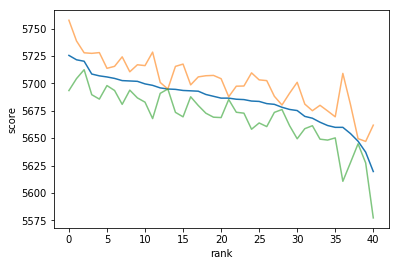

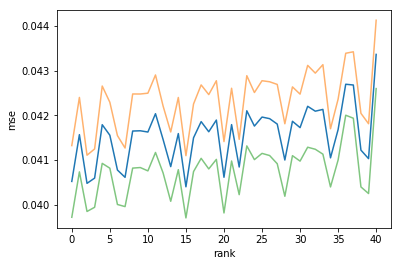

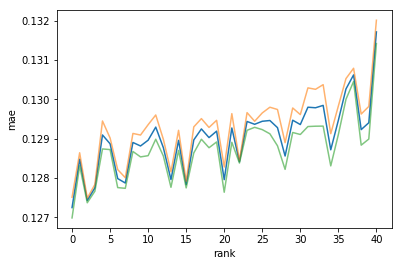

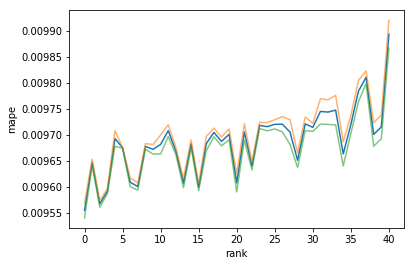

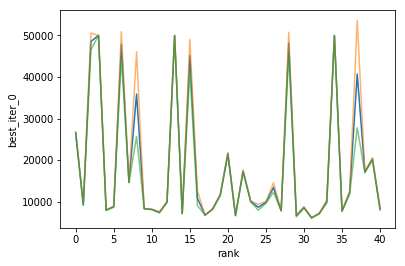

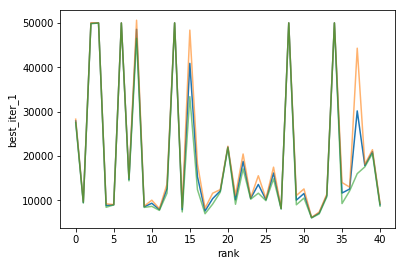

In [27]:
for m in metrics:
    sq = df_gsearch_results[m]
    sq_std = df_gsearch_results[m+'_std']
    plt.plot(sq)
    plt.plot(sq + sq_std, alpha=0.6)
    plt.plot(sq - sq_std, alpha=0.6)
    plt.xlabel('rank'); plt.ylabel(m); plt.show()

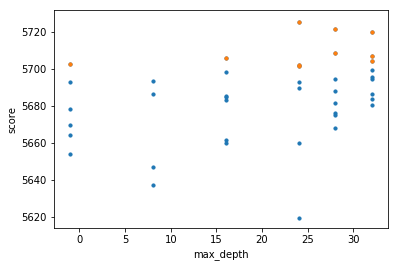

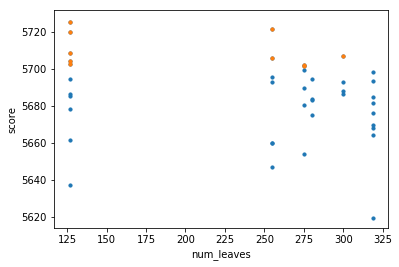

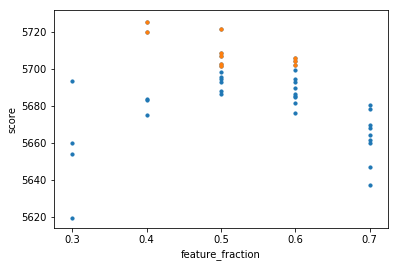

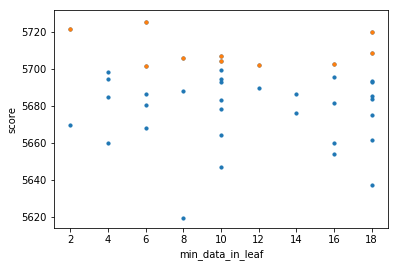

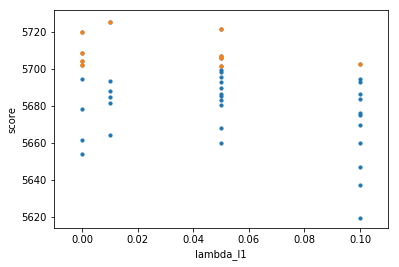

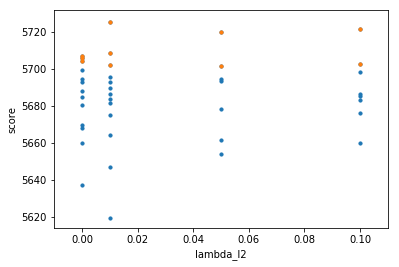

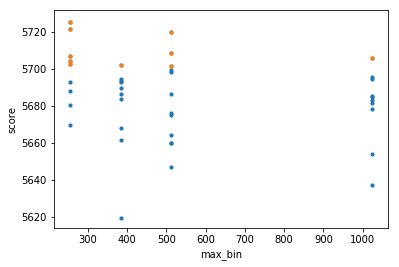

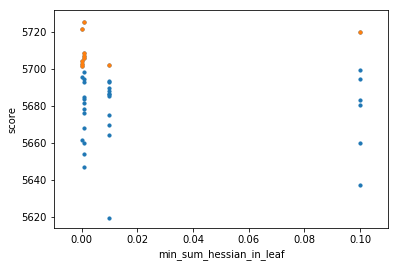

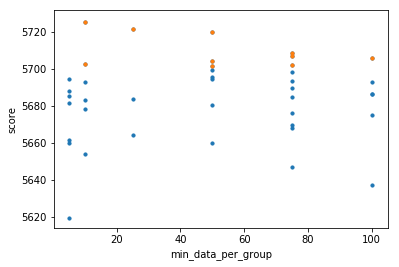

In [28]:
for p in params_gsearch.keys():
    plt.scatter(df_gsearch_results[p], df_gsearch_results['score'], s=10)
    plt.scatter(df_gsearch_results[p][:10], df_gsearch_results['score'][:10], s=10)
    plt.xlabel(p); plt.ylabel('score'); plt.show()

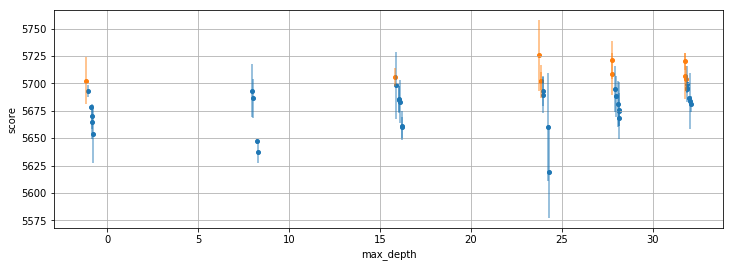

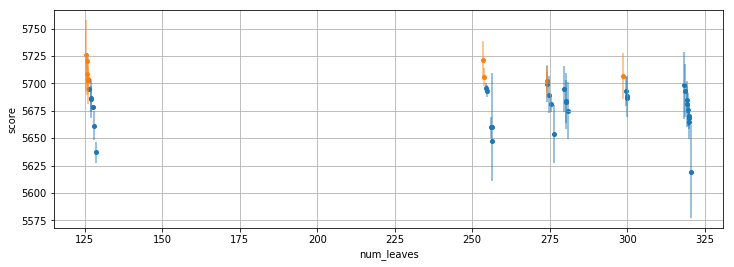

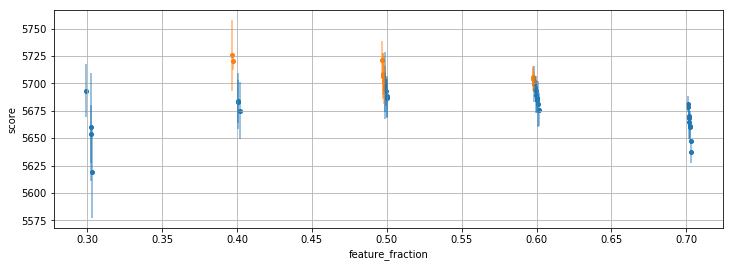

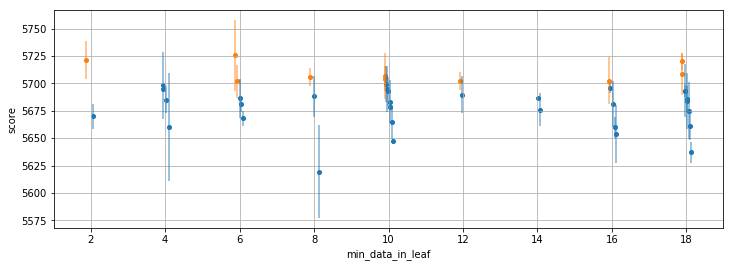

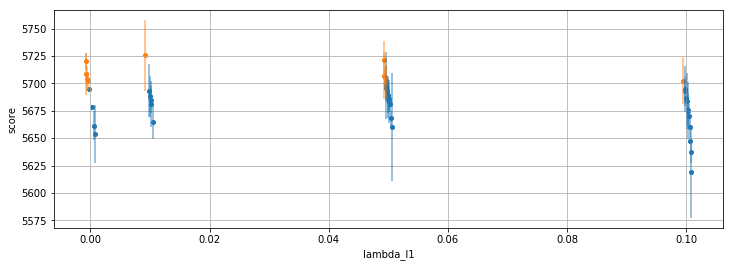

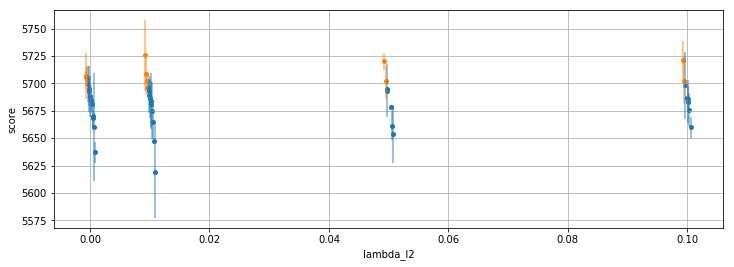

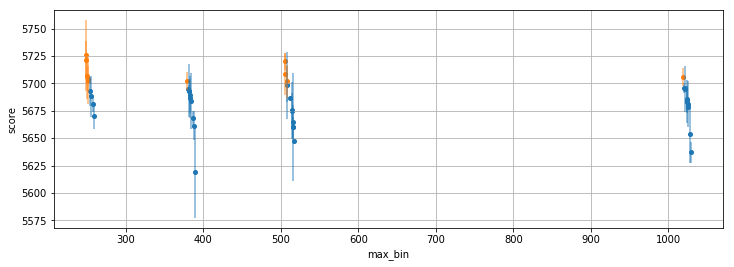

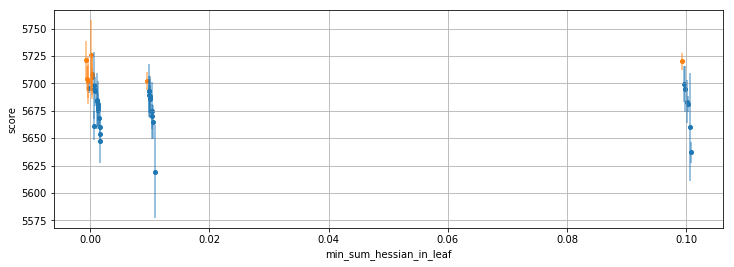

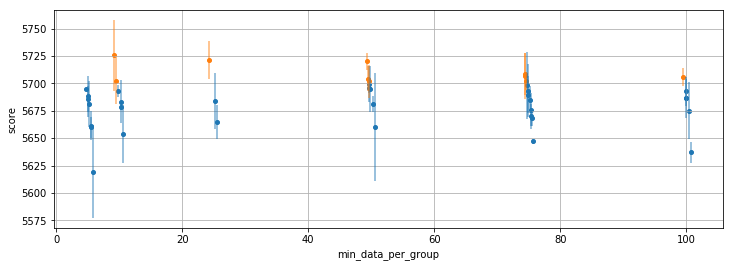

In [29]:
for p in params_gsearch.keys():
    plt.figure(figsize=(12, 4))
    x_sq = df_gsearch_results[p]
    x_shift = (x_sq.max() - x_sq.min())/3/len(x_sq)
    x_sq = x_sq + np.linspace(-x_shift, x_shift, len(x_sq), endpoint=True)
    plt.errorbar(x_sq[10:], df_gsearch_results['score'][10:], 
                 yerr=df_gsearch_results['score_std'][10:], linestyle="None", alpha=0.6)
    plt.errorbar(x_sq[:10], df_gsearch_results['score'][:10], 
                 yerr=df_gsearch_results['score_std'][:10], linestyle="None", alpha=0.6)
    plt.scatter(x_sq[10:], df_gsearch_results['score'][10:], s=16)
    plt.scatter(x_sq[:10], df_gsearch_results['score'][:10], s=16)
    plt.xlabel(p); plt.ylabel('score'); plt.grid(); plt.show()

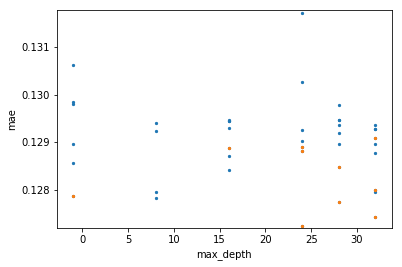

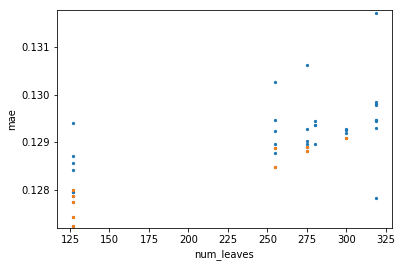

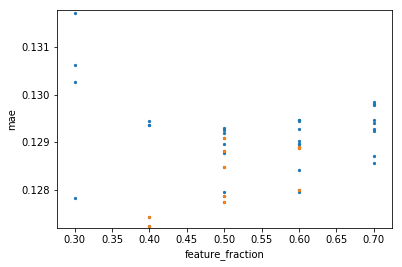

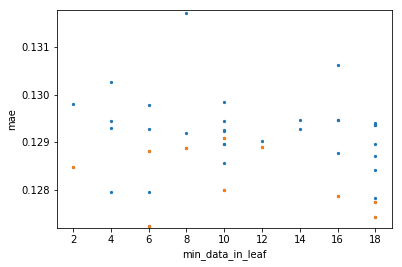

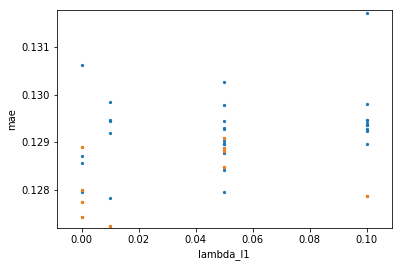

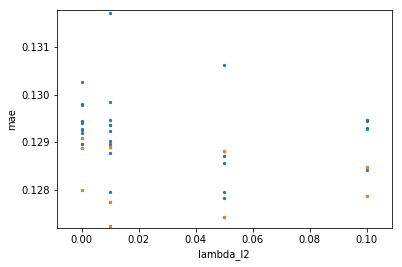

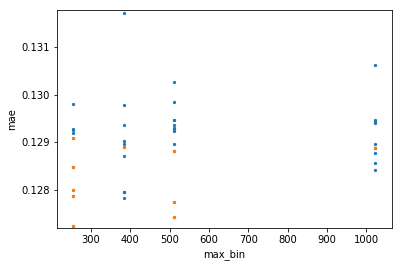

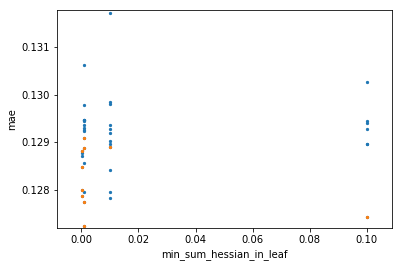

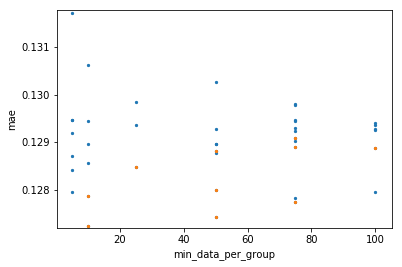

In [30]:
for p in params_gsearch.keys():
    plt.scatter(df_gsearch_results[p], df_gsearch_results['mae'], s=5)
    plt.scatter(df_gsearch_results[p][:10], df_gsearch_results['mae'][:10], s=5)
    plt.ylim(df_gsearch_results['mae'].min()-0.00005, df_gsearch_results['mae'].max()+0.00005)
    plt.xlabel(p); plt.ylabel('mae'); plt.show()

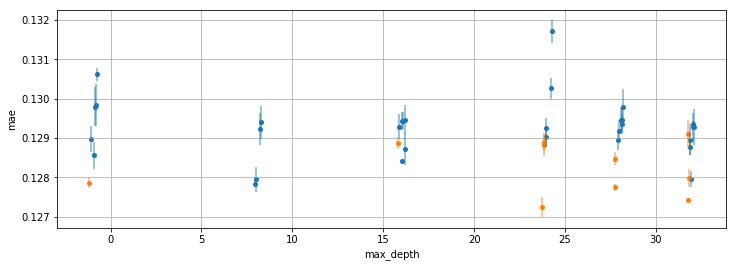

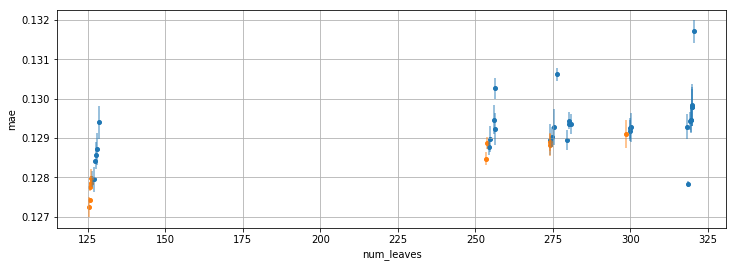

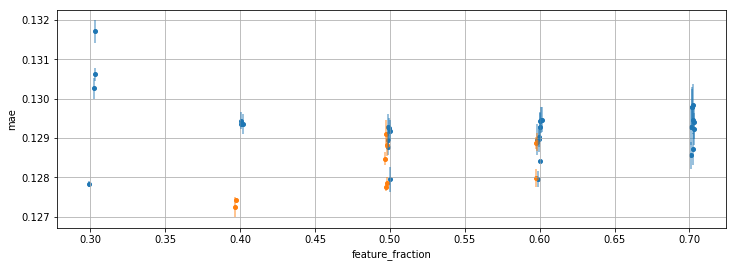

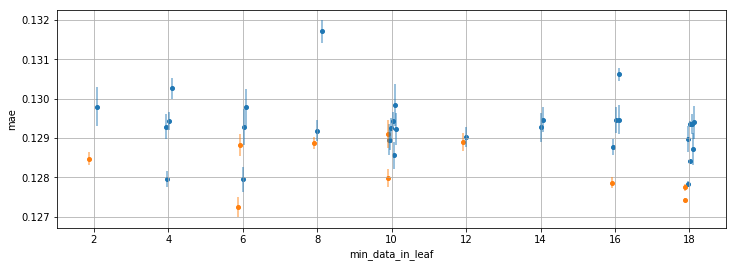

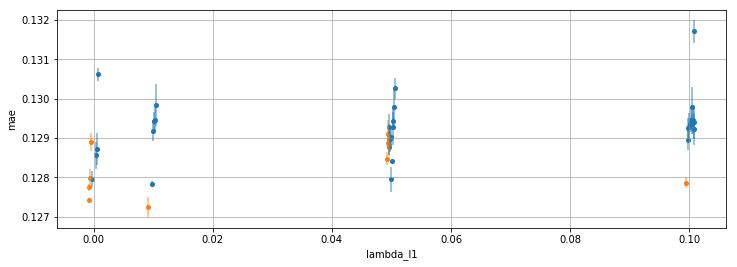

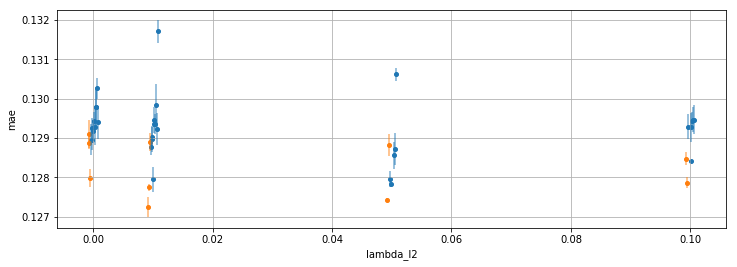

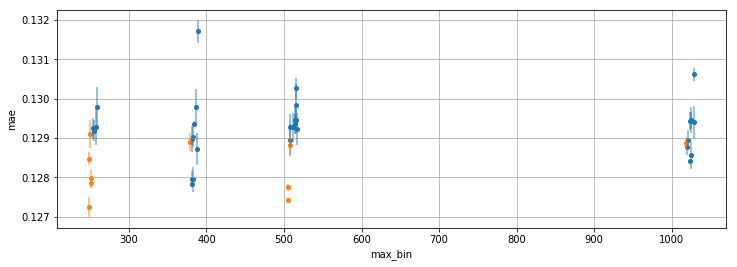

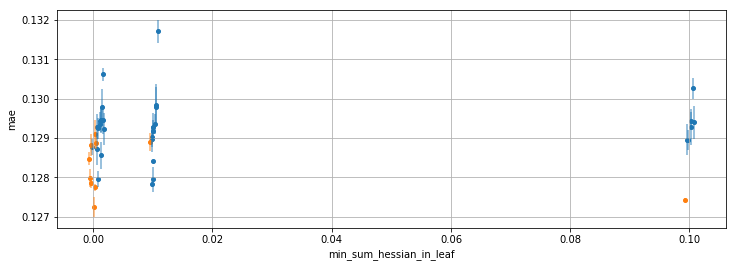

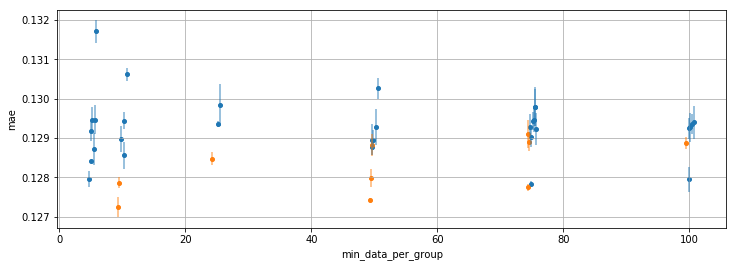

In [31]:
for p in params_gsearch.keys():
    plt.figure(figsize=(12, 4))
    x_sq = df_gsearch_results[p]
    x_shift = (x_sq.max() - x_sq.min())/3/len(x_sq)
    x_sq = x_sq + np.linspace(-x_shift, x_shift, len(x_sq), endpoint=True)
    plt.errorbar(x_sq[10:], df_gsearch_results['mae'][10:], 
                 yerr=df_gsearch_results['mae_std'][10:], linestyle="None", alpha=0.6)
    plt.errorbar(x_sq[:10], df_gsearch_results['mae'][:10], 
                 yerr=df_gsearch_results['mae_std'][:10], linestyle="None", alpha=0.6)
    plt.scatter(x_sq[10:], df_gsearch_results['mae'][10:], s=16)
    plt.scatter(x_sq[:10], df_gsearch_results['mae'][:10], s=16)
    plt.ylim(df_gsearch_results['mae'].min()-df_gsearch_results['mae_std'].max(), 
             df_gsearch_results['mae'].max()+df_gsearch_results['mae_std'].max())
    plt.xlabel(p); plt.ylabel('mae'); plt.grid(); plt.show()

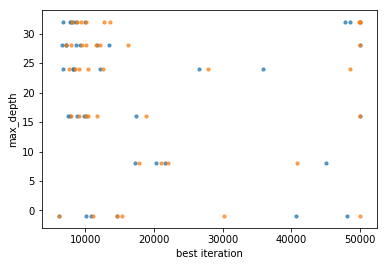

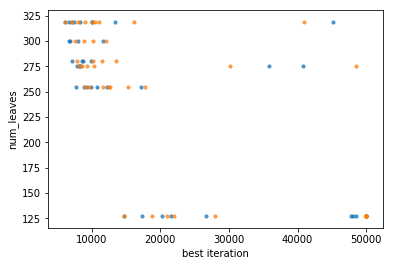

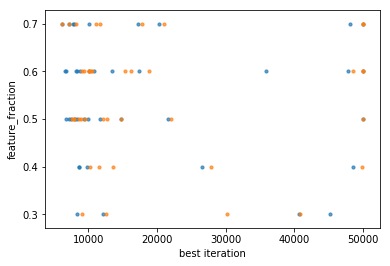

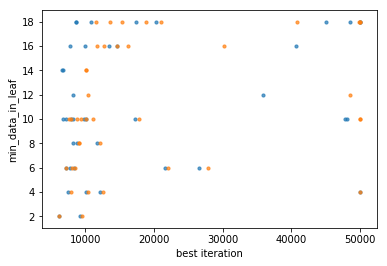

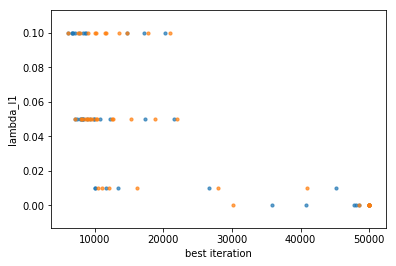

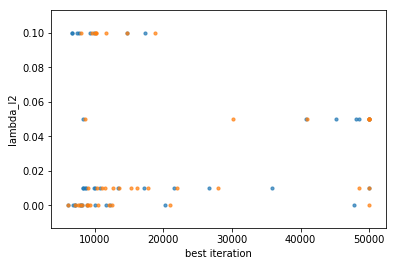

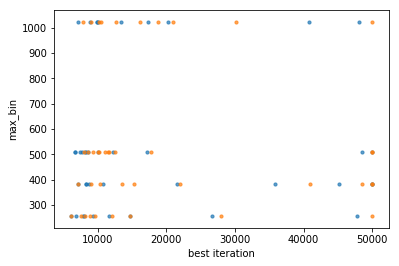

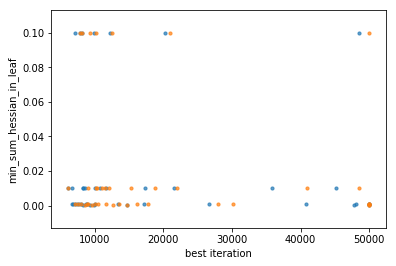

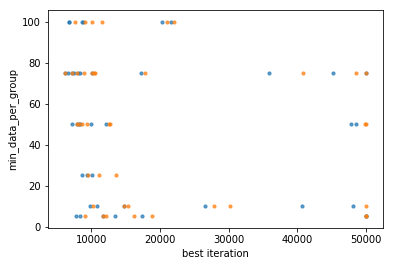

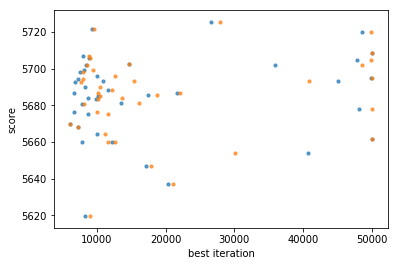

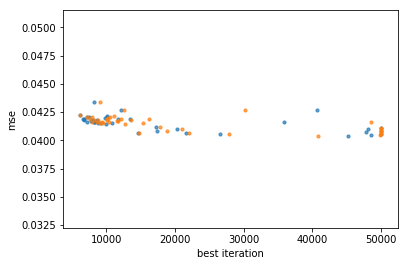

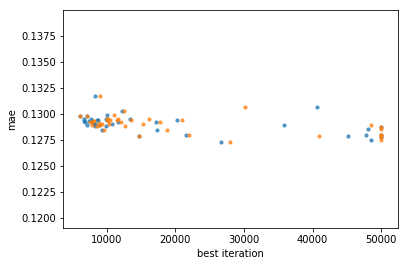

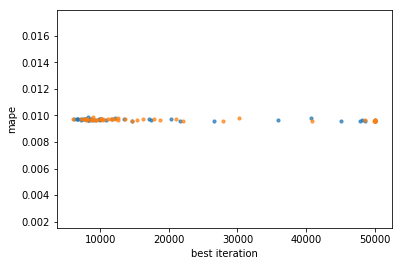

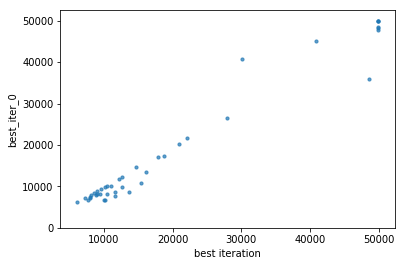

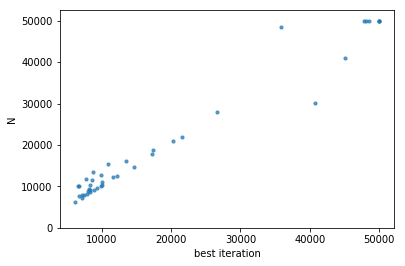

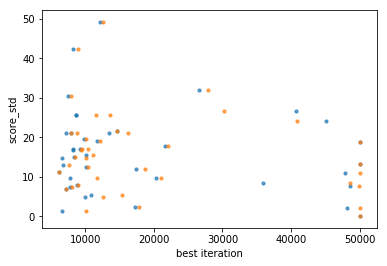

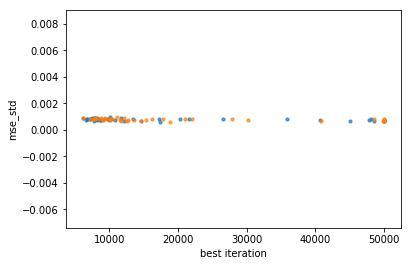

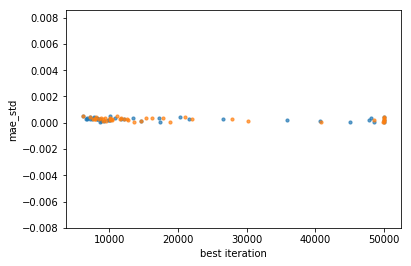

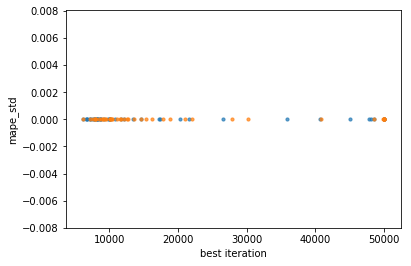

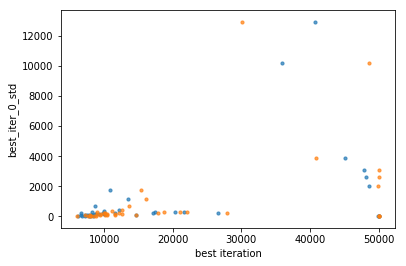

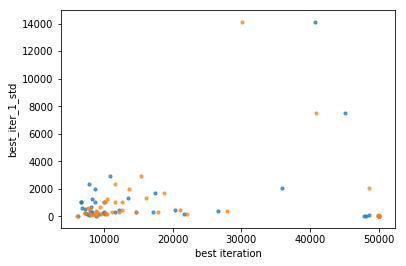

In [34]:
# best iteration
for c in df_gsearch_results.columns:
    for pg in price_groups:
        if c != 'best_iter_'+str(pg):
            plt.scatter(df_gsearch_results['best_iter_'+str(pg)], df_gsearch_results[c], s=10, 
                        label=str(pg), alpha=0.7)
            plt.ylabel(c)
        else:
            plt.hist(df_gsearch_results['best_iter_'+str(pg)], bins=30, label=str(pg), alpha=0.7)
            plt.ylabel('N')        
    plt.xlabel('best iteration')
    plt.show()

### Feature importance

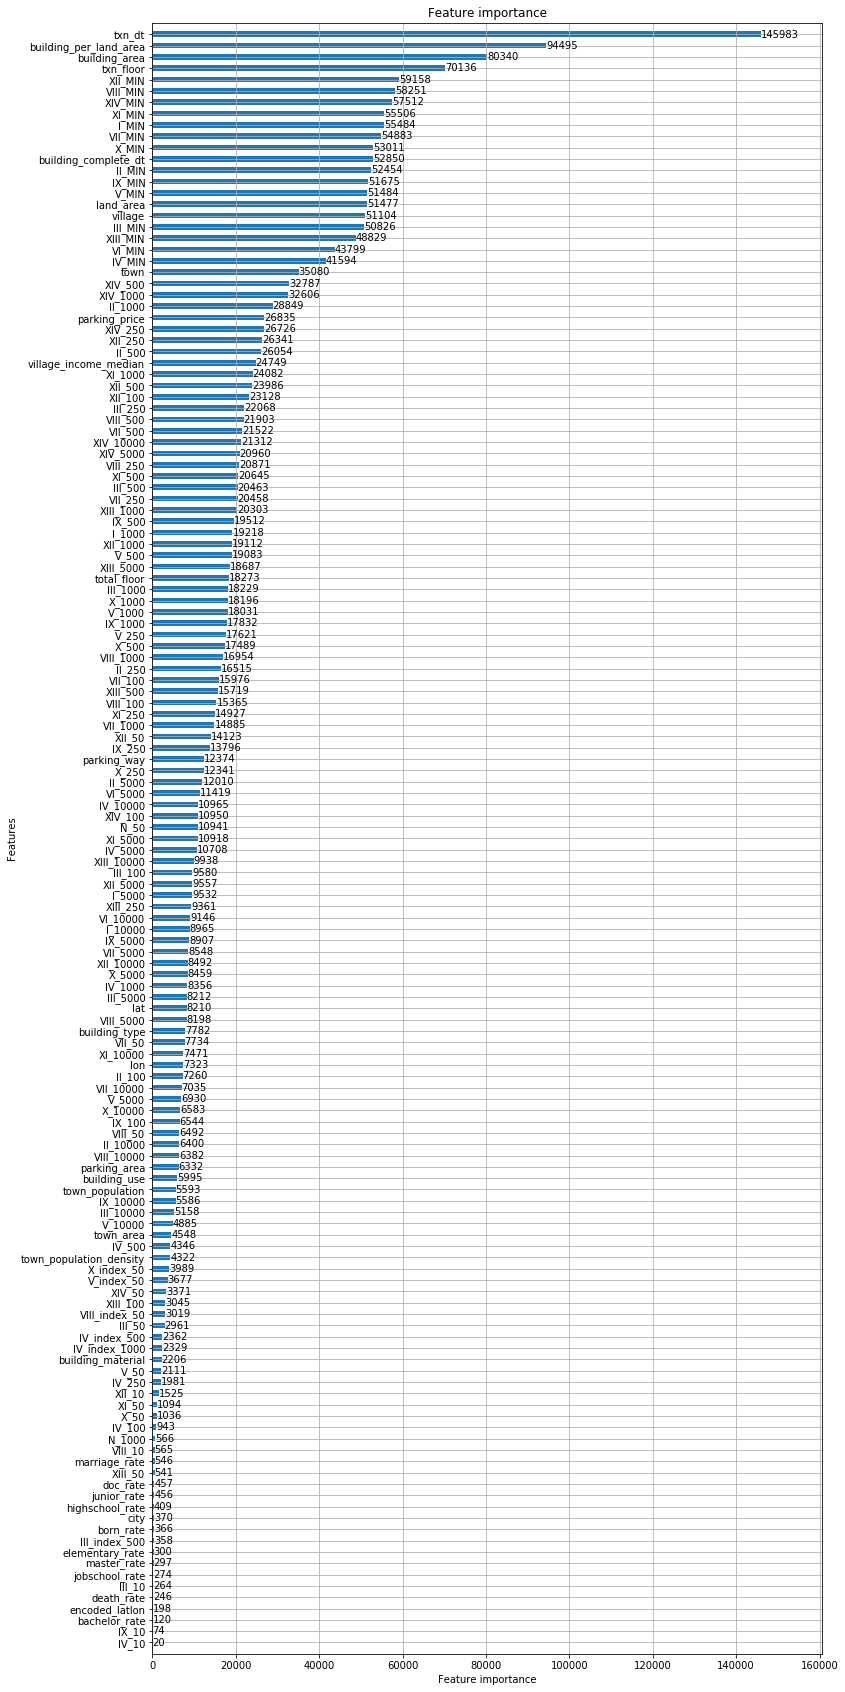

In [32]:
lgb.plot_importance(model, figsize=(12, 30), height=0.5) # 050, 051, 052
plt.show()

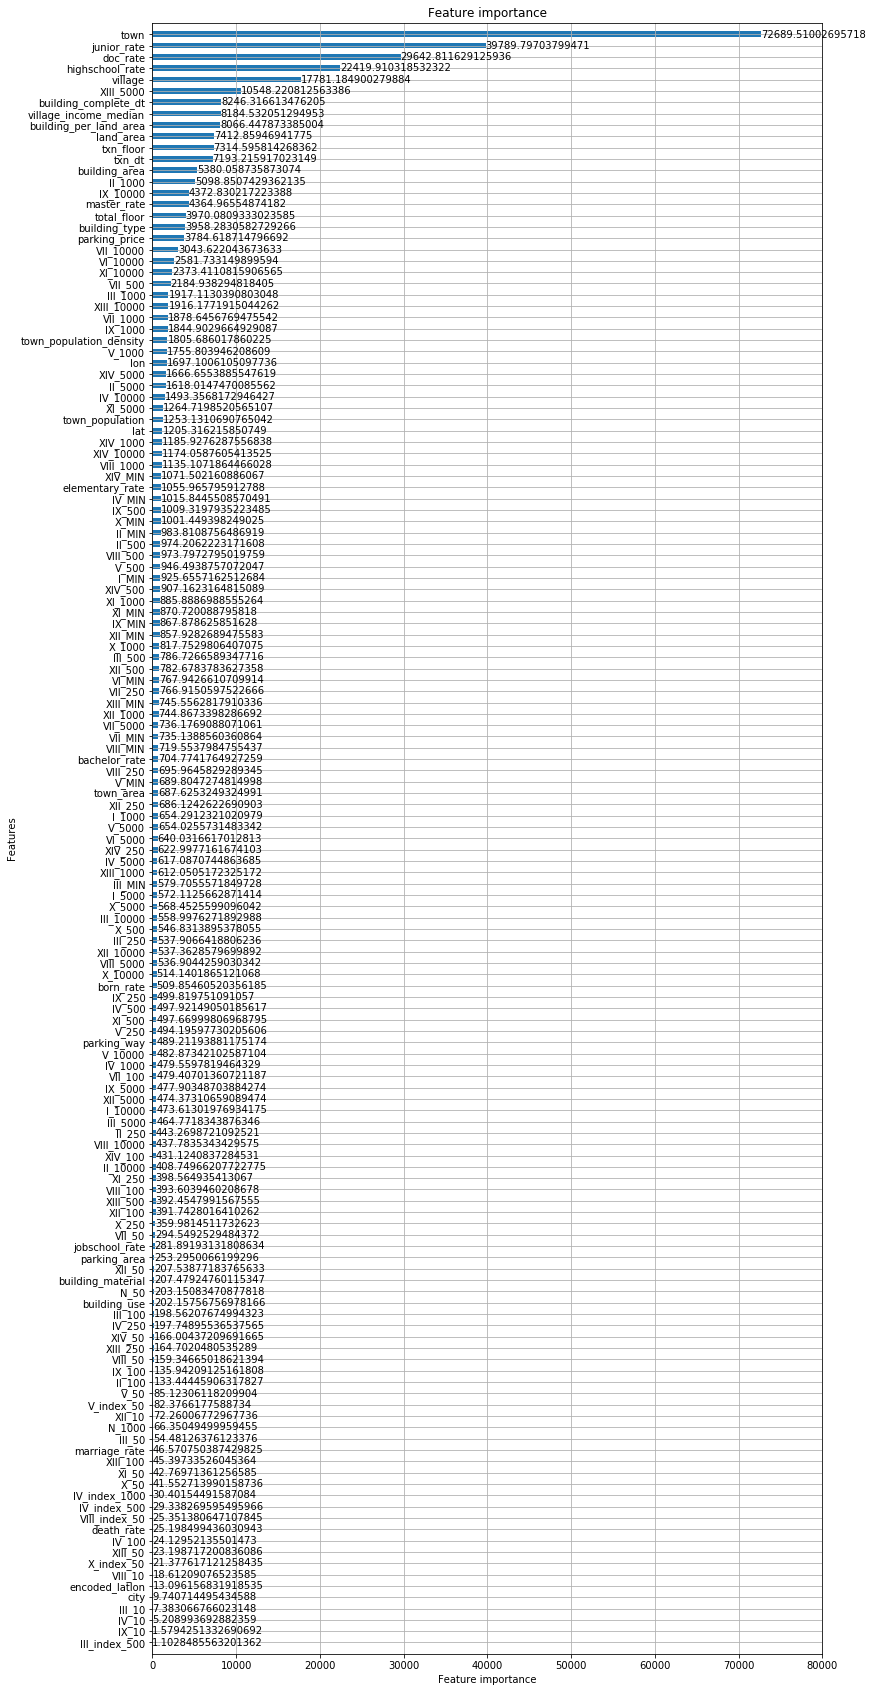

In [33]:
lgb.plot_importance(model, figsize=(12, 30), height=0.5, importance_type='gain') # 050, 051, 052
plt.show()